```
LSTM vs Transformer vs LLaMA vs Diff
```
- 파라미터 수 78만 정도의 작은 모델 & without GQA
- 작은 배치 사이즈

In [1]:
## Importing Libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 128
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 2048
EPOCHS = 1
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([2048, 64])
Target shape: torch.Size([2048, 64])
Sample 1: ------------------------------
Input sequence : erd:I would there were no age between sixteen andthree-and-twe
Target sequence: rd:I would there were no age between sixteen andthree-and-twen

Sample 2: ------------------------------
Input sequence : smother'd.But, God be thank'd, there's no need of me,And much 
Target sequence: mother'd.But, God be thank'd, there's no need of me,And much I

Sample 3: ------------------------------
Input sequence : s hear your firm resolve.BONA:Your grant, or your denial, sha
Target sequence:  hear your firm resolve.BONA:Your grant, or your denial, shal



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─GRU: 1-2                               [2048, 64, 256]           691,200
├─Dropout: 1-3                           [2048, 64, 256]           --
├─LayerNorm: 1-4                         [2048, 64, 256]           512
├─Linear: 1-5                            [2048, 64, 256]           65,792
├─Linear: 1-6                            [2048, 64, 65]            16,705
Total params: 782,529
Trainable params: 782,529
Non-trainable params: 0
Total mult-adds (G): 90.78
Input size (MB): 1.05
Forward/backward pass size (MB): 1007.68
Params size (MB): 3.13
Estimated Total Size (MB): 1011.86

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)


Epoch 1/1, Train Loss: 1.8876, Val Loss: 2.0073, Epoch Time: 13.77s Average Vram Usage: 53.47MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
answer_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0]])
num = 0
while len(answer_text) == len(generated_text):
    num += 1
    answer_text += ''.join([idx_to_char[idx.item()] for idx in val_sample[num]])[-1]    
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)
print(answer_text)
print()

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, deel 'flient
And on that
My do fander of where greate,
Muse in any pood thy in sof we is the hall farther a knuld garines:
Thin wither leftles take say mother, what this voy ceard wit, but driou the mid you che,
wo have you so though, he daptogh prever are not will the kind sice thee dair, sif, dithim'd yumar, fid Gities
And dove furmsif, best sone for the setule matcher, that the couth wonder it your thou lroaths virtterus
Cerot's your with a privey preevend of chem.
To was beedF:
We chercon


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro



In [23]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [24]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([ 0.6636, -2.7419, -3.3868, -2.8372, -1.5797, -0.3829, -4.4019, -1.9397,
        -3.9474, -1.0281], device='cuda:0')

Predicted next character:
w


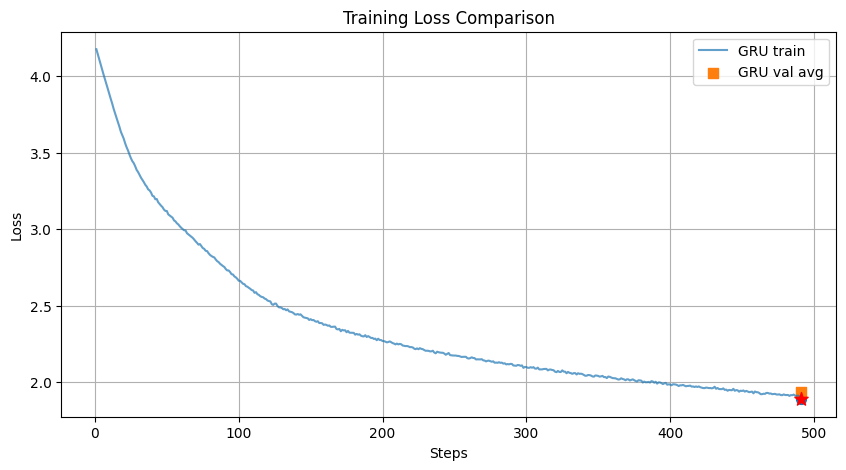

In [25]:
plot_loss_comparisons()

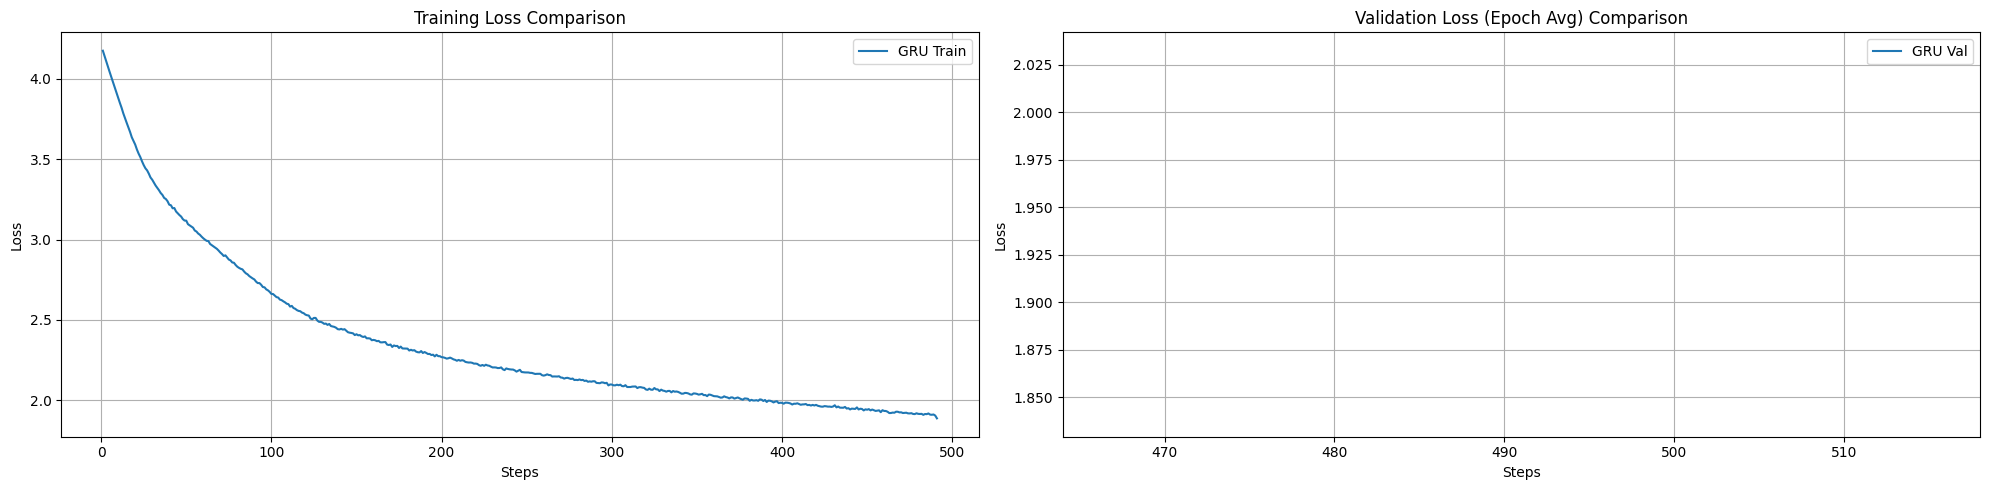

In [26]:
plot_separate_train_val(loss_comparison_dict)

In [27]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [28]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    print("-"*50)
    print(answer_text)
    print("-"*50)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [29]:
del gru
torch.cuda.empty_cache()

import gc
gc.collect

<function gc.collect(generation=2)>

## Model 2: Modern Transformer(LLaMA - 2023)

In [30]:
# Hyperparameters for Transformer
NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 480
DROPOUT = 0.1

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    # FFN_DIM = HIDDEN_DIM
    FFN_DIM = 320
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [32]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 128)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=128, out_features=128, bias=False)
        (wk): Linear(in_features=128, out_features=128, bias=False)
        (wv): Linear(in_features=128, out_features=128, bias=False)
        (wo): Linear(in_features=128, out_features=128, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=128, out_features=320, bias=False)
        (w2): Linear(in_features=320, out_features=128, bias=False)
        (w3): Linear(in_features=128, out_features=320, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=128, out_features=65, bias=False)
)

In [33]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [2048, 64, 65]            --
├─Embedding: 1-1                         [2048, 64, 128]           8,320
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-1                 [2048, 64, 128]           128
│    │    └─SelfAttention: 3-2           [2048, 64, 128]           65,568
│    │    └─Dropout: 3-3                 [2048, 64, 128]           --
│    │    └─RMSNorm: 3-4                 [2048, 64, 128]           128
│    │    └─FeedForward: 3-5             [2048, 64, 128]           122,880
│    │    └─Dropout: 3-6                 [2048, 64, 128]           --
│    └─TransformerBlock: 2-2             [2048, 64, 128]           --
│    │    └─RMSNorm: 3-7                 [2048, 64, 128]           128
│    │    └─SelfAttention: 3-8           [2048, 64, 128]           65,

In [34]:
# train_and_test("LLaMA", llama, start_text)

In [35]:
del llama
torch.cuda.empty_cache()
gc.collect

<function gc.collect(generation=2)>

## Model 3: Mamba

In [36]:
import torch
import torch.nn as nn

from torch.nn import functional as F
from einops import rearrange

In [37]:
# Configuration flags and hyperparameters
USE_MAMBA = 1
DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM = 0

In [38]:
# User-defined hyperparameters
d_model = 8
n_layers = 6
state_size = 128  # Example state size
seq_len = SEQUENCE_LENGTH  # Example sequence length
batch_size = BATCH_SIZE  # Example batch size
current_batch_size = batch_size
different_batch_size = False
h_new = None
temp_buffer = None

In [39]:
class S6(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super(S6, self).__init__()

        self.fc1 = nn.Linear(d_model, d_model, device=device)
        self.fc2 = nn.Linear(d_model, state_size, device=device)
        self.fc3 = nn.Linear(d_model, state_size, device=device)

        self.seq_len = seq_len
        self.d_model = d_model
        self.state_size = state_size

        #self.A = nn.Parameter(torch.ones(d_model, state_size, device=device))
        self.A = nn.Parameter(F.normalize(torch.ones(d_model, state_size, device=device), p=2, dim=-1))
        nn.init.xavier_uniform_(self.A)

        self.B = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)
        self.C = torch.zeros(batch_size, self.seq_len, self.state_size, device=device)

        self.delta = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)
        self.dA = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.dB = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)

        # h should have dimensions [batch_size, seq_len, d_model, state_size]
        self.h = torch.zeros(batch_size, self.seq_len, self.d_model, self.state_size, device=device)
        self.y = torch.zeros(batch_size, self.seq_len, self.d_model, device=device)


    def discretization(self):
        # discretization function is defined based on the MAMBA paper's description using ZOH on page 28
        # in Section C : Mechanics on Selective SSMs
        # See also "Zero-order hold discretization" maths proof inside https://studywolf.wordpress.com/tag/zero-order-hold/
        """
        Here is an explanation of the mathematical rationale for the formulation of Δt used in Mamba:
        The key idea is that Δt controls the discretization rate of the continuous SSM dynamics. By making Δt input-dependent, it introduces selectivity into the discrete transition matrices.
        Specifically, in Mamba they parameterize Δt as:
        Δt = τΔ(Parameter + sΔ(xt))
        Where:
        - Parameter is a learned scalar parameter that controls the baseline discretization rate
        - sΔ(xt) is a projection that makes Δt input-dependent by computing a value based on xt
        - τΔ(x) = softplus(x) transforms the result to be positive through the softplus nonlinearity
        The rationale for this formulation is:
        - Parameter provides a reasonable default discretization rate
        - sΔ(xt) injects input-dependence through the projection
        - softplus ensures Δt is positive as required to be a valid timestep
        - The projection sΔ allows the model to learn to modulate Δt based on the input xt
        - This modulation creates selectivity in how rapidly or slowly the states update
        So in summary, the learned input-dependent projection allows Δt, and thus the discrete dynamics, to become selective. The softplus and scalar parameter provide useful inductive biases on top of this flexibility.
        The end result is discrete transition matrices that are selective on the input, enabling powerful sequence modeling capabilities.
        Credit: Claude2 AI chatbot
        """

        # inverse() only supports square matrix
        #dB = torch.matmul(torch.inverse(A * delta), torch.matmul(dA - torch.eye(A.shape[0]), B))
        self.dB = torch.einsum("bld,bln->bldn", self.delta, self.B)

        # https://github.com/state-spaces/mamba/blob/0131c1e94a46fc9f70bcfc9d57962963bb2f0b9e/mamba_ssm/modules/mamba_simple.py#L240
        #dA = torch.matrix_exp(A * delta)  # matrix_exp() only supports square matrix
        self.dA = torch.exp(torch.einsum("bld,dn->bldn", self.delta, self.A))
        #print(f"self.dA.shape = {self.dA.shape}")
        #print(f"self.dA.requires_grad = {self.dA.requires_grad}")

        return self.dA, self.dB

    def forward(self, x):
        # Refer to Algorithm 2 in the MAMBA paper
        self.B = self.fc2(x)
        self.C = self.fc3(x)
        self.delta = F.softplus(self.fc1(x))

        # Uses ZOH as in MAMBA, Hungry Hippo still uses bilinear transform for discretization
        self.discretization()

        if DIFFERENT_H_STATES_RECURRENT_UPDATE_MECHANISM:  # this will trigger in-place runtime error if without using `h_new`
          
            global current_batch_size
            current_batch_size = x.shape[0]

            if self.h.shape[0] != current_batch_size:
                #print("Adjusting h_new for the different batch size of input data `x`")
                different_batch_size = True

                # Resize self.h to match the current batch size
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h[:current_batch_size, ...]) + rearrange(x, "b l d -> b l d 1") * self.dB

            else:
                different_batch_size = False
                h_new =  torch.einsum('bldn,bldn->bldn', self.dA, self.h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            self.y = torch.einsum('bln,bldn->bld', self.C, h_new)

            # Update self.h with the detached state of h_new
            # Only do this if retaining gradients for self.h is not necessary for backprop
            # Otherwise, store h_new in a temporary list and update self.h after the loop
            global temp_buffer
            temp_buffer = h_new.detach().clone() if not self.h.requires_grad else h_new.clone()
  
            return self.y

        else:  # this will not trigger in-place runtime error
            # h should have dimensions [batch_size, seq_len, d_model, state_size]
            h = torch.zeros(x.size(0), self.seq_len, self.d_model, self.state_size, device=x.device)
            y = torch.zeros_like(x)

            h =  torch.einsum('bldn,bldn->bldn', self.dA, h) + rearrange(x, "b l d -> b l d 1") * self.dB

            # y needs to have a shape of [batch_size, seq_len, d_model]
            y = torch.einsum('bln,bldn->bld', self.C, h)

            return y

In [ ]:
class MambaBlock(nn.Module):
    def __init__(self, seq_len, d_model, state_size, device):
        super(MambaBlock, self).__init__()

        self.inp_proj = nn.Linear(d_model, 2*d_model, device=device)
        self.out_proj = nn.Linear(2*d_model, d_model, device=device)

        # For residual skip connection
        self.D = nn.Linear(d_model, 2*d_model, device=device)

        # Set _no_weight_decay attribute on bias
        self.out_proj.bias._no_weight_decay = True

        # Initialize bias to a small constant value
        nn.init.constant_(self.out_proj.bias, 1.0)

        self.S6 = S6(seq_len, 2*d_model, state_size, device)

        # Add 1D convolution with kernel size 3
        self.conv = nn.Conv1d(seq_len, seq_len, kernel_size=3, padding=1, device=device)

        # Add linear layer for conv output
        self.conv_linear = nn.Linear(2*d_model, 2*d_model, device=device)

        # rmsnorm
        self.norm = RMSNorm(d_model)

    def forward(self, x):
        """
        x_proj.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv.shape = torch.Size([batch_size, seq_len, 2*d_model])
        x_conv_act.shape = torch.Size([batch_size, seq_len, 2*d_model])
        """
        # Refer to Figure 3 in the MAMBA paper
        x = self.norm(x)

        x_proj = self.inp_proj(x)
        #print(f"x_proj.shape = {x_proj.shape}")

        # Add 1D convolution with kernel size 3
        x_conv = self.conv(x_proj)
        #print(f"x_conv.shape = {x_conv.shape}")

        x_conv_act = F.silu(x_conv)
        #print(f"x_conv_act.shape = {x_conv_act.shape}")

        # Add linear layer for conv output
        x_conv_out = self.conv_linear(x_conv_act)
        #print(f"x_conv_out.shape = {x_conv_out.shape}")

        x_ssm = self.S6(x_conv_out)
        x_act = F.silu(x_ssm)  # Swish activation can be implemented as x * sigmoid(x)
        #print(f"x_act.shape = {x_act.shape}")

        # residual skip connection with nonlinearity introduced by multiplication
        x_residual = F.silu(self.D(x))
        #print(f"x_residual.shape = {x_residual.shape}")
        x_combined = x_act * x_residual
        #print(f"x_combined.shape = {x_combined.shape}")

        x_out = self.out_proj(x_combined)
        #print(f"x_out.shape = {x_out.shape}")

        return x_out

In [43]:
class Mamba(nn.Module):
    def __init__(self, seq_len, d_model, state_size, n_layers, device):
        super(Mamba, self).__init__()
        self.layers = nn.ModuleList([MambaBlock(seq_len, d_model, state_size, device) for _ in range(n_layers)])
        # self.mamba_block1 = MambaBlock(seq_len, d_model, state_size, device)
        # self.mamba_block2 = MambaBlock(seq_len, d_model, state_size, device)
        # self.mamba_block3 = MambaBlock(seq_len, d_model, state_size, device)

    def forward(self, x):
        for layer in self.layers:
            print(x.shape)
            x = layer(x)
        return x

In [49]:
x = torch.rand(batch_size, seq_len, d_model, device=device)
# Create the Mamba model
mamba = Mamba(seq_len, d_model, state_size, n_layers, device)
# Forward pass
test_output = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 79.15 GiB of which 997.69 MiB is free. Process 3644092 has 78.17 GiB memory in use. Of the allocated memory 77.57 GiB is allocated by PyTorch, and 93.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [48]:
summary(mamba.to(device), input_size=(batch_size, seq_len, d_model))

torch.Size([2048, 64, 8])


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
train_and_test("mamba", mamba, start_text)

x.shape=torch.Size([2048, 64]), self.norm=RMSNorm()


RuntimeError: The size of tensor a (8) must match the size of tensor b (64) at non-singleton dimension 1